# STAT 5243 Final Project -- ChemBERTa Section

## Install & import relevant packages

In [ ]:
!pip install pubchempy
!pip install pandas
!pip install numpy
!pip install transformers 
!pip install torch
!pip install scikit-learn
!pip install rdkit

In [17]:
import pandas as pd
import numpy as np
import pubchempy as pcp
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModel
import pickle
import random
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score
from sklearn.preprocessing import MultiLabelBinarizer
import os
from typing import List, Tuple, Dict, Set
from rdkit import Chem

In [18]:
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [19]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

## 1. STRINGs Retrieval

In [20]:
base_path = "/root/autodl-tmp/FinalProjectRemote/ChemBERTa/"

In [21]:
file_path = base_path + 'bio-decagon-combo.csv'

print(f"Loading data from {file_path} to extract unique drug IDs...")
df_combo = pd.read_csv(file_path)

unique_drug_a = df_combo['STITCH 1'].unique()
unique_drug_b = df_combo['STITCH 2'].unique()

all_unique_drug_ids = pd.unique(np.concatenate((unique_drug_a, unique_drug_b)))

print(f"Total unique drug IDs found: {len(all_unique_drug_ids)}")
print("Example IDs:", all_unique_drug_ids[:5])

Loading data from /root/autodl-tmp/FinalProjectRemote/ChemBERTa/bio-decagon-combo.csv to extract unique drug IDs...
Total unique drug IDs found: 645
Example IDs: ['CID000002173' 'CID000005206' 'CID000003929' 'CID000001302'
 'CID000005267']


In [ ]:

def get_smiles_from_cids(cid_list):
    drug_data = []
    total_cids = len(cid_list)
    
    print(f"Starting to fetch SMILES for {total_cids} drugs...")
    
    for i, cid_string in enumerate(cid_list):
        smiles = None
        status = 'Error'
        cid_number = None

        if (i + 1) % 20 == 0:
            print(f"  Processed {i + 1} / {total_cids} CIDs...")

        try:
            # clean the strings (e.g., "CID000002173" -> 2173)
            if isinstance(cid_string, str) and cid_string.startswith('CID'):
                cid_number = int(cid_string.replace('CID', ''))
            else:
                cid_number = int(cid_string)

            # retrieve from PubChem
            compound = pcp.Compound.from_cid(cid_number)
            
            # get the smiles strings
            if compound and compound.canonical_smiles:
                smiles = compound.canonical_smiles
                status = 'Found'
            else:
                status = 'Not Found'

            drug_data.append({
                'cid_string': cid_string,
                'smiles': smiles,
                'status': status
            })

        except Exception as e:
            # handel any not found STICH IDs
            drug_data.append({
                'cid_string': cid_string,
                'smiles': None,
                'status': f'Error: {e}'
            })

    print(f"...Fetching complete. Processed {total_cids} CIDs.")
    
    df_results = pd.DataFrame(drug_data)
    return df_results

smiles_df = get_smiles_from_cids(all_unique_drug_ids)

print("\n--- SMILES Retrieval Results ---")
print(smiles_df.head())

In [ ]:
smiles_df.to_csv('smiles.csv', index=False)

In [ ]:
smiles_df[smiles_df['status'] != 'Found']

In [ ]:
smiles_df.to_csv('drug_smiles_mapping_full.csv', index=False) 

In [ ]:
# confirms uniqueness of the strings

def verify_structural_uniqueness(csv_file):
    print(f"Loading data from {csv_file}...")
    try:
        df = pd.read_csv(csv_file)
    except FileNotFoundError:
        print(f"Error: File {csv_file} not found.")
        return

    if 'smiles' not in df.columns:
        print("Error: 'smiles' column not found in the CSV.")
        return

    # Filter out any rows where smiles might be missing just in case
    initial_count = len(df)
    df = df.dropna(subset=['smiles'])
    if len(df) < initial_count:
        print(f"Warning: Dropped {initial_count - len(df)} rows with missing SMILES.")

    print(f"Processing {len(df)} SMILES strings...")
    
    inchi_keys = []
    invalid_smiles_count = 0

    for idx, smiles in enumerate(df['smiles']):
        mol = Chem.MolFromSmiles(smiles)
        if mol:
            # Generate InChIKey
            inchi_key = Chem.MolToInchiKey(mol)
            inchi_keys.append(inchi_key)
        else:
            print(f"Warning: Invalid SMILES at row {idx}: {smiles}")
            invalid_smiles_count += 1
            inchi_keys.append(None)

    df['InChIKey'] = inchi_keys
    
    # Remove rows where InChIKey could not be generated
    df_valid = df.dropna(subset=['InChIKey'])
    
    total_valid = len(df_valid)
    unique_inchikeys = df_valid['InChIKey'].nunique()

    print("\n--- Structural Uniqueness Verification Results ---")
    print(f"Total valid SMILES processed: {total_valid}")
    print(f"Total unique InChIKeys: {unique_inchikeys}")

    if total_valid == unique_inchikeys:
        print("\n✅ SUCCESS: All processed SMILES strings produced unique full InChIKeys.")
        print("This confirms that no duplicate or structurally redundant compounds are present in the dataset.")
    else:
        print(f"\n❌ ISSUE DETECTED: Found {total_valid - unique_inchikeys} duplicate entries based on InChIKeys.")
        duplicates = df_valid[df_valid.duplicated(subset=['InChIKey'], keep=False)]
        print("Duplicate entries:")
        print(duplicates[['cid_string', 'smiles', 'InChIKey']].sort_values(by='InChIKey'))


In [ ]:
csv_path = 'drug_smiles_mapping_full.csv'
verify_structural_uniqueness(csv_path)

## 2. ChemBERTa Embeddings

In [ ]:
D_EMB = 384 
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class DrugEncoder(nn.Module):
    def __init__(self, input_dim=D_EMB, output_dim=D_EMB):
        super(DrugEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, input_dim * 2),
            nn.ReLU(),
            nn.Linear(input_dim * 2, output_dim) # Output dimension D_EMB
        )

    def forward(self, x):
        return self.encoder(x)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

print("Loading ChemBERTa model and tokenizer...")

tokenizer = AutoTokenizer.from_pretrained("DeepChem/ChemBERTa-77M-MLM")
model = AutoModel.from_pretrained("DeepChem/ChemBERTa-77M-MLM")
model.eval()

smiles_file = 'drug_smiles_mapping_full.csv'
print(f"Loading SMILES data from {smiles_file}...")
df_smiles = pd.read_csv(smiles_file)

df_found_smiles = df_smiles[df_smiles['status'] == 'Found'].copy()
print(f"Found {len(df_found_smiles)} drugs with valid SMILES.")

cid_list = df_found_smiles['cid_string'].tolist()
smiles_list = df_found_smiles['smiles'].tolist()


drug_embeddings_map = {}
batch_size = 32 
print(f"Generating embeddings in batches of {batch_size}...")

with torch.no_grad():
    for i in range(0, len(smiles_list), batch_size):
        batch_cids = cid_list[i : i + batch_size]
        batch_smiles = smiles_list[i : i + batch_size]
        
        print(f"  Processing batch {i//batch_size + 1} / {len(smiles_list)//batch_size + 1}")
        
        inputs = tokenizer(
            batch_smiles, 
            return_tensors='pt', 
            padding=True,
            truncation=True,
            max_length=512
        )
        
        inputs = {key: val.to(device) for key, val in inputs.items()}
        
        outputs = model(**inputs)
        
        cls_embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()
        
        for cid, embedding in zip(batch_cids, cls_embeddings):
            drug_embeddings_map[cid] = embedding

print("...Embedding generation complete.")


output_embeddings_file = 'ChemBERTa_drug_embeddings.pkl'

with open(output_embeddings_file, 'wb') as f:
    pickle.dump(drug_embeddings_map, f)

print(f"\nSuccessfully generated and saved {len(drug_embeddings_map)} drug embeddings.")
print(f"Embeddings map saved to: {output_embeddings_file}")


first_cid = list(drug_embeddings_map.keys())[0]
print(f"Example embedding for {first_cid}:")
print(drug_embeddings_map[first_cid][:10]) 
print(f"Embedding dimension: {drug_embeddings_map[first_cid].shape}")

## 3. Contrastive Loss

In [ ]:
# ====== CONFIG ======
OUTPUT_DIM = 128
LR = 5e-4              
BATCH_SIZE = 64
NUM_EPOCHS = 20
TEMPERATURE = 0.1
SEED = 42
D_EMB = 384 

torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def contrastive_loss_symmetric(emb_i, emb_j, temperature=TEMPERATURE):
    def _loss(query, key):
        query = F.normalize(query, dim=1)
        key = F.normalize(key, dim=1)
        sim_matrix = torch.matmul(query, key.T) / temperature
        pos_mask = torch.eye(sim_matrix.size(0), dtype=torch.bool, device=query.device)
        log_prob = F.log_softmax(sim_matrix, dim=1)
        return -log_prob[pos_mask].mean()
    
    return (_loss(emb_i, emb_j) + _loss(emb_j, emb_i)) / 2

class DrugEncoder(nn.Module):
    def __init__(self, input_dim=D_EMB, output_dim=OUTPUT_DIM):
        super().__init__()
        self.encoder = nn.Sequential(
            # Layer 1: Maintain dim, learn features
            nn.Linear(input_dim, input_dim),
            nn.BatchNorm1d(input_dim),
            nn.ReLU(),
            nn.Dropout(0.1),
            
            # Layer 2: Compress
            nn.Linear(input_dim, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.1),
            
            # Layer 3: Project
            nn.Linear(512, output_dim)
        )
        
    def forward(self, x):
        return self.encoder(x)

class ContrastiveDrugDataset(Dataset):
    def __init__(self, embeddings_map, df_combo):
        self.cids = list(embeddings_map.keys())
        
        print("Preprocessing: Applying Global Z-Score Whitening...")
        all_embs = torch.stack([torch.from_numpy(embeddings_map[c]) for c in self.cids]).float()
        
        # Calculate stats
        mean = all_embs.mean(dim=0, keepdim=True)
        std = all_embs.std(dim=0, keepdim=True) + 1e-6
        
        # Whiten
        all_embs = (all_embs - mean) / std
        
        # Check integrity
        if torch.isnan(all_embs).any():
            raise ValueError("NaNs found after whitening!")
            
        # Update mapping with whitened embeddings
        whitened_map = {}
        whitened_numpy = all_embs.numpy()
        for i, cid in enumerate(self.cids):
            whitened_map[cid] = whitened_numpy[i]
            
        self.cid_to_emb = whitened_map

        print(f"Processing combo data ({len(df_combo)} rows)...")
        valid_cids = set(self.cids)
        valid_mask = df_combo['STITCH 1'].isin(valid_cids) & df_combo['STITCH 2'].isin(valid_cids)
        df_valid = df_combo[valid_mask].copy()
        
        s1 = df_valid['STITCH 1'].values
        s2 = df_valid['STITCH 2'].values
        
        # Canonical sort row-wise
        min_s = np.minimum(s1, s2)
        max_s = np.maximum(s1, s2)
        
        # Unique pairs
        pairs = set(zip(min_s, max_s))
        self.positive_pairs = list(pairs)
        print(f"Dataset ready. {len(self.positive_pairs)} positive pairs. {len(self.cids)} unique drugs.")

    def __len__(self):
        return len(self.positive_pairs)

    def __getitem__(self, idx):
        cid_a, cid_b = self.positive_pairs[idx]
        emb_a = torch.tensor(self.cid_to_emb[cid_a], dtype=torch.float32)
        emb_b = torch.tensor(self.cid_to_emb[cid_b], dtype=torch.float32)
        return emb_a, emb_b



In [ ]:
def contrastive_loss_train(drug_embeddings_map, df_combo):
    dataset = ContrastiveDrugDataset(drug_embeddings_map, df_combo)
    dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
    
    print("\n--- 2. TRAINING SETUP (Optimization V2) ---")
    print("Architecture: 3-Layer Deep MLP (BN+ReLU)")
    print(f"Loss Temp: {TEMPERATURE}")
    model = DrugEncoder().to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=LR)
    
    print(f"Device: {DEVICE}")
    print(f"Batch Size: {BATCH_SIZE}")
    print(f"LR: {LR}")
    
    print("\n--- 3. STARTING TRAINING (Input Whitened + Deep Projector) ---")
    best_loss = float('inf')
    
    for epoch in range(NUM_EPOCHS):
        model.train()
        total_loss = 0
        batch_count = 0
        
        for emb_a, emb_b in dataloader:
            emb_a, emb_b = emb_a.to(DEVICE), emb_b.to(DEVICE)
            
            optimizer.zero_grad()
            
            # Forward
            z_a = model(emb_a)
            z_b = model(emb_b)
            
            # Loss
            loss = contrastive_loss_symmetric(z_a, z_b)
            
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            batch_count += 1
            
        avg_loss = total_loss / batch_count
        print(f"Epoch {epoch+1}/{NUM_EPOCHS}, Loss: {avg_loss:.4f}")
        
        if avg_loss < best_loss:
            best_loss = avg_loss

    print(f"\nTraining Complete. Best Loss: {best_loss:.4f}")
    if best_loss < 4.10:
         print("Success: Loss is consistently below random baseline (4.15).")
         
    model.eval()
    refined_map = {}
    with torch.no_grad():
        for cid, emb in dataset.cid_to_emb.items():
            emb_tensor = torch.tensor(emb, dtype=torch.float32).to(DEVICE).unsqueeze(0)
            refined = model(emb_tensor).cpu().numpy().flatten()
            refined_map[cid] = refined
        
    return refined_map

In [ ]:
with open('ChemBERTa_drug_embeddings.pkl', 'rb') as f:
    drug_embeddings_map = pickle.load(f)
    
file_path = 'bio-decagon-combo.csv'
df_combo = pd.read_csv(file_path)

In [ ]:
refined_map = contrastive_loss_train(drug_embeddings_map, df_combo)

In [ ]:
output_file = 'refined_drug_embeddings_fixed.pkl'
with open(output_file, 'wb') as f:
    pickle.dump(refined_map, f)

print(f"Saved refined embeddings to '{output_file}'")

## 4. Training

In [25]:
D_EMB = 128
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class DrugPairDataset(Dataset):
    def __init__(self, pairs: List[Tuple[str, str]], drug_embeddings_map: Dict[str, np.ndarray], labels: np.ndarray, is_binary: bool):
        self.pairs = [tuple(p) for p in pairs]
        self.cid_to_emb = drug_embeddings_map
        self.labels = labels
        self.is_binary = is_binary

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        cid_a, cid_b = self.pairs[idx]

        emb_a = torch.tensor(self.cid_to_emb[cid_a], dtype=torch.float32)
        emb_b = torch.tensor(self.cid_to_emb[cid_b], dtype=torch.float32)

        y = self.labels[idx]
        y = torch.as_tensor(y, dtype=torch.float32)
        if self.is_binary:
            y = y.squeeze().view(1)
        else:
            y = y.squeeze()

        return emb_a, emb_b, y

class CrossAttentionFusion(nn.Module):
    def __init__(self, embed_dim=D_EMB, num_output_classes=1, is_binary=True):
        super(CrossAttentionFusion, self).__init__()

        self.attn = nn.MultiheadAttention(
            embed_dim=embed_dim,
            num_heads=8,
            batch_first=True
        )

        # Deep MLP Head (512 -> 1024 -> 2048)
        self.mlp_head = nn.Sequential(
            # Layer 1: Input (embed_dim*2) -> 512
            nn.Linear(embed_dim * 2, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(negative_slope=0.1),
            nn.Dropout(0.2),

            # Layer 2: 512 -> 1024
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(negative_slope=0.1),
            nn.Dropout(0.2),

            # Layer 3: 1024 -> 2048
            nn.Linear(1024, 2048),
            nn.BatchNorm1d(2048),
            nn.LeakyReLU(negative_slope=0.1),
            nn.Dropout(0.2),

            # Output Layer: 2048 -> Num Classes
            nn.Linear(2048, num_output_classes)
        )

        self.is_binary = is_binary

    def forward(self, emb_a, emb_b):
        # 1. A queries B (A->B interaction)
        attn_out_a, _ = self.attn(
            query=emb_a.unsqueeze(1),
            key=emb_b.unsqueeze(1),
            value=emb_b.unsqueeze(1)
        )

        # 2. B queries A (B->A interaction)
        attn_out_b, _ = self.attn(
            query=emb_b.unsqueeze(1),
            key=emb_a.unsqueeze(1),
            value=emb_a.unsqueeze(1)
        )

        fused_vector = torch.cat([attn_out_a.squeeze(1), attn_out_b.squeeze(1)], dim=1)

        logits = self.mlp_head(fused_vector)

        # Return logits (no sigmoid) for use with BCEWithLogitsLoss
        return logits

class FocalLoss(nn.Module):

    def __init__(self, alpha=0.25, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        # Use binary_cross_entropy_with_logits which is autocast-safe
        # inputs should be logits (before sigmoid)
        BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')

        # Calculate Pt (probability of correct class)
        # For BCEWithLogits, we need to manually compute probabilities
        probs = torch.sigmoid(inputs)
        Pt = targets * probs + (1 - targets) * (1 - probs)

        Focal_Term = (1 - Pt) ** self.gamma

        alpha_term = targets * self.alpha + (1 - targets) * (1 - self.alpha)

        focal_loss = alpha_term * Focal_Term * BCE_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

def save_checkpoint(model, optimizer, epoch, metrics, filename):
    torch.save({'epoch': epoch, 'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimizer.state_dict(), 'metrics': metrics}, filename)
    print(f"Checkpoint saved to {filename}")

def save_results(results_df, filename="experiment_results.csv"):
    if os.path.exists(filename):
        existing_df = pd.read_csv(filename)
        results_df = pd.concat([existing_df, results_df], ignore_index=True)
    results_df.to_csv(filename, index=False)
    print(f"\n--- Results saved to {filename} ---")

def train_model(model, train_loader, optimizer, criterion, scaler):
    model.train()
    total_loss = 0
    for emb_a, emb_b, labels in train_loader:
        emb_a, emb_b, labels = emb_a.to(DEVICE), emb_b.to(DEVICE), labels.to(DEVICE)

        optimizer.zero_grad()
        
        # Use autocast for mixed precision training
        with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
            predictions = model(emb_a, emb_b)
            loss = criterion(predictions, labels)
        
        # Scale loss and backward
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        total_loss += loss.item()
    return total_loss / len(train_loader)

def evaluate_model(model, data_loader, is_binary):
    model.eval()
    all_preds_proba = []
    all_labels = []

    with torch.no_grad():
        for emb_a, emb_b, labels in data_loader:
            emb_a, emb_b = emb_a.to(DEVICE), emb_b.to(DEVICE)

            # Get logits and apply sigmoid to get probabilities
            logits = model(emb_a, emb_b)
            preds_tensor = torch.sigmoid(logits).cpu().detach()
            preds = np.array(preds_tensor.tolist())
            all_preds_proba.extend(preds)

            all_labels.extend(labels.cpu().tolist())

    all_preds_proba = np.array(all_preds_proba)
    all_labels = np.array(all_labels)

    if is_binary:
        metric_score = roc_auc_score(all_labels.squeeze(), all_preds_proba.squeeze())
        return metric_score, 'AUROC'
    else:
        # Multi-Label Task Metric: F1-Micro
        all_preds = (all_preds_proba > 0.5).astype(int)
        metric_score = f1_score(all_labels, all_preds, average='micro', zero_division=0)
        return metric_score, 'F1-Micro'


def prepare_data_hierarchical(embeddings_file: str, combo_file: str, map_file: str, is_binary_task: bool):

    print(f"1. Loading Refined embeddings from {embeddings_file}...")
    with open(embeddings_file, 'rb') as f:
        grover_emb_map = pickle.load(f)
    all_drugs = set(grover_emb_map.keys())
    print(f"   -> Loaded {len(all_drugs)} unique drug embeddings.")

    df_combo = pd.read_csv(combo_file)

    print("Filtering side effects (>= 500 occurrences)...")
    se_col = 'Polypharmacy Side Effect'
    if se_col in df_combo.columns:
        se_counts = df_combo[se_col].value_counts()
        valid_se = se_counts[se_counts >= 500].index
        print(f"Original unique side effects: {len(se_counts)}")
        print(f"Keeping {len(valid_se)} unique side effects.")
        df_combo = df_combo[df_combo[se_col].isin(valid_se)]
        print(f"Filtered dataset size: {len(df_combo)} rows.")
    else:
        print(f"Warning: Column '{se_col}' not found. Skipping filtering.")

    print(f"2. Loading hierarchical map from {map_file}...")
    df_map = pd.read_csv(map_file)

    FINE_GRAINED_COL = 'Side Effect Name'
    COARSE_GRAINED_COL = 'Disease Class'

    side_effect_to_parent_map = pd.Series(
        df_map[COARSE_GRAINED_COL].values,
        index=df_map[FINE_GRAINED_COL]
    ).to_dict()
    print(f"   -> Map built: {len(side_effect_to_parent_map)} fine-grained effects mapped to categories.")

    pair_to_side_effects_map: Dict[frozenset, Set[str]] = {}

    for _, row in df_combo.iterrows():
        id_a = str(row['STITCH 1']).strip()
        id_b = str(row['STITCH 2']).strip()
        side_effect_code = row['Side Effect Name']

        if id_a in all_drugs and id_b in all_drugs:
            pair = frozenset([id_a, id_b])

            if pair not in pair_to_side_effects_map:
                pair_to_side_effects_map[pair] = set()
            pair_to_side_effects_map[pair].add(side_effect_code)

    print(f"3. Found {len(pair_to_side_effects_map)} unique, embedded drug pairs.")

    all_pairs: List[frozenset] = list(pair_to_side_effects_map.keys())
    all_labels_list_of_sets = [pair_to_side_effects_map[pair] for pair in all_pairs]

    coarse_grained_labels_list_of_sets = []
    all_original_se_codes = set()

    for se_set in all_labels_list_of_sets:
        coarse_set = set()
        for se_code in se_set:
            all_original_se_codes.add(se_code)
            parent_se = side_effect_to_parent_map.get(se_code, se_code)
            coarse_set.add(parent_se)

        coarse_grained_labels_list_of_sets.append(coarse_set)

    total_initial_classes = len(all_original_se_codes)

    mlb = MultiLabelBinarizer()
    y = mlb.fit_transform(coarse_grained_labels_list_of_sets)

    N_CLASSES = len(mlb.classes_)
    print(f"   -> Original # of Classes: {total_initial_classes}")
    print(f"   -> New # of Classes: {N_CLASSES}")

    X_train, X_temp, y_train, y_temp = train_test_split(
            all_pairs, y, test_size=0.2, random_state=42
        )

    X_val, X_test, y_val, y_test = train_test_split(
            X_temp, y_temp, test_size=0.5, random_state=42
        )

    print(f"   -> Split Stats: Train={len(X_train)} (80%), Val={len(X_val)} (10%), Test={len(X_test)} (10%)")

    return X_train, X_val, X_test, y_train, y_val, y_test, grover_emb_map, N_CLASSES



def prepare_data(embeddings_file: str, combo_file: str, is_binary_task: bool):
    print(f"1. Loading ChemBERTa embeddings from {embeddings_file}...")
    with open(embeddings_file, 'rb') as f:
        # Load embeddings into grover_emb_map
        grover_emb_map = pickle.load(f)
    all_drugs = set(grover_emb_map.keys())
    print(f"   -> Loaded {len(all_drugs)} unique drug embeddings.")

    df_combo = pd.read_csv(combo_file)

    print("Filtering side effects (>= 500 occurrences)...")
    se_col = 'Polypharmacy Side Effect'
    if se_col in df_combo.columns:
        se_counts = df_combo[se_col].value_counts()
        valid_se = se_counts[se_counts >= 500].index
        print(f"Original unique side effects: {len(se_counts)}")
        print(f"Keeping {len(valid_se)} unique side effects.")
        df_combo = df_combo[df_combo[se_col].isin(valid_se)]
        print(f"Filtered dataset size: {len(df_combo)} rows.")
    else:
        print(f"Warning: Column '{se_col}' not found. Skipping filtering.")

    # --- BINARY TASK PATH ---
    if is_binary_task:
        print("   -> Preparing data for BINARY classification (Drug Interaction Existence)...")
        positive_pairs = set()
        for _, row in df_combo.iterrows():
            # Use STITCH IDs, sorted to ensure unique pairs
            d1 = str(row['STITCH 1']).strip()
            d2 = str(row['STITCH 2']).strip()

            # Ensure both drugs are in our embedding map
            if d1 in grover_emb_map and d2 in grover_emb_map:
                pair = tuple(sorted([d1, d2]))
                positive_pairs.add(pair)

        all_pairs = list(positive_pairs)
        n_pos = len(all_pairs)
        print(f"   -> Found {n_pos} positive pairs.")

        # Generate Negative Samples (1:1 Ratio) by random sampling
        np.random.seed(42)
        all_drugs_list = list(all_drugs)

        while len(all_pairs) < 2 * n_pos:
            d1, d2 = np.random.choice(all_drugs_list, 2, replace=False)
            pair = tuple(sorted([d1, d2]))
            if pair not in positive_pairs:
                all_pairs.append(pair)

        # Labels: 1 for positives, 0 for negatives
        labels = np.array([1] * n_pos + [0] * n_pos)

        # 80/10/10 Split for Binary
        # 1. Train (80%) vs Temp (20%)
        X_train_pairs, X_temp_pairs, y_train, y_temp = train_test_split(
            all_pairs, labels, test_size=0.2, random_state=42, stratify=labels
        )

        # 2. Temp (20%) -> Val (10%) + Test (10%)
        X_val_pairs, X_test_pairs, y_val, y_test = train_test_split(
            X_temp_pairs, y_temp, test_size=0.5, random_state=42, stratify=y_temp
        )

        print(f"   -> Binary Split Stats: Train={len(X_train_pairs)}, Val={len(X_val_pairs)}, Test={len(X_test_pairs)}")

        # Reshape labels for compatibility
        return X_train_pairs, X_val_pairs, X_test_pairs, y_train.reshape(-1, 1), y_val.reshape(-1, 1), y_test.reshape(-1, 1), grover_emb_map

    # --- MULTI-LABEL TASK PATH ---
    print("   -> Preparing data for MULTI-LABEL classification...")
    pair_to_side_effects_map: Dict[frozenset, Set[str]] = {}

    for _, row in df_combo.iterrows():
        id_a = str(row['STITCH 1']).strip()
        id_b = str(row['STITCH 2']).strip()
        side_effect = row['Polypharmacy Side Effect']

        if id_a in all_drugs and id_b in all_drugs:
            pair = frozenset([id_a, id_b])

            if pair not in pair_to_side_effects_map:
                pair_to_side_effects_map[pair] = set()
            pair_to_side_effects_map[pair].add(side_effect)

    print(f"2. Found {len(pair_to_side_effects_map)} unique, embedded drug pairs.")

    all_pairs: List[frozenset] = list(pair_to_side_effects_map.keys())
    all_labels_list_of_sets = [pair_to_side_effects_map[pair] for pair in all_pairs]

    mlb = MultiLabelBinarizer()
    y = mlb.fit_transform(all_labels_list_of_sets)

    N_CLASSES = len(mlb.classes_)
    print(f"   -> MultiLabelBinarizer found {N_CLASSES} total unique side effects.")

    # 80/10/10 Split for Multi-Label
    X_train, X_temp, y_train, y_temp = train_test_split(
        all_pairs, y, test_size=0.2, random_state=42
    )

    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=0.5, random_state=42
    )

    print(f"   -> Split Stats: Train={len(X_train)} (80%), Val={len(X_val)} (10%), Test={len(X_test)} (10%)")

    return X_train, X_val, X_test, y_train, y_val, y_test, grover_emb_map, N_CLASSES

In [42]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

def plot_tsne_from_embedding_pickle(embeddings_file, title, max_points=None, random_state=42, degree_map=None, degree_label='Drug degree (num interactions)'):
    with open(embeddings_file, 'rb') as f:
        emb_map = pickle.load(f)

    drug_ids = sorted(list(emb_map.keys()))
    if max_points is not None and len(drug_ids) > max_points:
        rng = np.random.default_rng(random_state)
        drug_ids = list(rng.choice(drug_ids, size=max_points, replace=False))

    if len(drug_ids) < 3:
        print('t-SNE skipped: not enough points')
        return None

    A = np.stack([np.asarray(emb_map[d], dtype=np.float32) for d in drug_ids], axis=0)
    perplexity = min(30, A.shape[0] - 1)

    tsne = TSNE(
        n_components=2,
        perplexity=perplexity,
        learning_rate='auto',
        init='random',
        random_state=random_state,
    )
    A_2d = tsne.fit_transform(A)

    colors = None
    if degree_map is not None:
        colors = np.asarray([degree_map.get(str(d), 0) for d in drug_ids], dtype=np.float32)

    plt.figure(figsize=(6, 6))
    sc = plt.scatter(A_2d[:, 0], A_2d[:, 1], s=15, alpha=0.8, c=colors, cmap='viridis')
    if colors is not None:
        plt.colorbar(sc, label=degree_label)
    plt.title(title)
    plt.xlabel('Dim 1')
    plt.ylabel('Dim 2')
    plt.tight_layout()
    plt.show()

    return A_2d


### Binary

In [26]:
def run_binary_training(embeddings_file, combo_file, epochs=20):
    print("\n--- Starting Binary Classification with Cross-Attention (Balanced) ---")
    
    # 1. Data Setup (Balanced, 80/10/10)
    # This prepares 3 sets: Train (80%), Calidation (10%), Test (10%)
    X_train_pairs, X_val_pairs, X_test_pairs, y_train, y_val, y_test, emb_map = prepare_data(embeddings_file, combo_file, is_binary_task=True)

    train_dataset = DrugPairDataset(X_train_pairs, emb_map, y_train, is_binary=True)
    val_dataset = DrugPairDataset(X_val_pairs, emb_map, y_val, is_binary=True)
    test_dataset = DrugPairDataset(X_test_pairs, emb_map, y_test, is_binary=True)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    # 2. Model Setup
    model = CrossAttentionFusion(embed_dim=D_EMB, num_output_classes=1, is_binary=True).to(DEVICE)

    criterion = FocalLoss(alpha=0.25, gamma=2).to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    
    # Create GradScaler for mixed precision training
    scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())

    best_metric = 0.0
    task_name = "binary"

    # 3. Training and Saving Checkpoint
    for epoch in range(epochs):
        train_loss = train_model(model, train_loader, optimizer, criterion, scaler)

        # Evaluate on Validation Set for model selection
        current_metric, metric_name = evaluate_model(model, val_loader, is_binary=True)

        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Val {metric_name}: {current_metric:.4f}")

        if current_metric > best_metric:
            best_metric = current_metric
            print(f"  --> New best model saved (Val)! {metric_name}: {best_metric:.4f}")
            save_checkpoint(
                model,
                optimizer,
                epoch,
                {metric_name: current_metric},
                filename=f'{task_name}_best_model.pth'
            )

    # Final Test Eval using the Best Saved Model
    print("\n--- Final Evaluation on TEST SET (Using Best Validation Model) ---")
    if os.path.exists(f'{task_name}_best_model.pth'):
        checkpoint = torch.load(f'{task_name}_best_model.pth', map_location=DEVICE)
        model.load_state_dict(checkpoint['model_state_dict'])
        print(f"Loaded best model from epoch {checkpoint['epoch']}")

    model.eval()
    all_preds_proba, all_labels = [], []
    with torch.no_grad():
        for emb_a, emb_b, labels in test_loader:
            # Move tensors to device
            emb_a, emb_b = emb_a.to(DEVICE), emb_b.to(DEVICE)
            
            # Get logits and apply sigmoid
            logits = model(emb_a, emb_b)
            preds = torch.sigmoid(logits).squeeze().cpu().numpy()
            all_preds_proba.extend(preds)
            all_labels.extend(labels.squeeze().cpu().numpy())

    auroc = roc_auc_score(all_labels, all_preds_proba)
    aupr = average_precision_score(all_labels, all_preds_proba)

    print("\n--- Binary Model Final Evaluation (Test Set) ---")
    print(f"AUROC (Area Under ROC Curve): {auroc:.4f}")
    print(f"AUPR (Average Precision-Recall): {aupr:.4f}")

    results_df = pd.DataFrame({
        'Task': [task_name],
        'Model': ['Cross-Attention'],
        'Epochs': [epochs],
        'AUROC': [auroc],
        'AUPR': [aupr],
        'Best_Metric': [best_metric]
    })
    save_results(results_df, 'experiment_results.csv')

In [27]:
EMBEDDINGS_FILE = base_path + 'refined_drug_embeddings_fixed.pkl'
COMBO_FILE = base_path + 'bio-decagon-combo.csv'
NUM_EPOCHS = 20
print("\n[PHASE 1] Running Binary Classification (Balanced Data)")
start_time_binary = time.time()
    
run_binary_training(
        embeddings_file=EMBEDDINGS_FILE, 
        combo_file=COMBO_FILE, 
        epochs=NUM_EPOCHS
    )
    
end_time_binary = time.time()
print(f"\n✅ PHASE 1 Complete. Time taken: {end_time_binary - start_time_binary:.2f} seconds.")


[PHASE 1] Running Binary Classification (Balanced Data)

--- Starting Binary Classification with Cross-Attention (Balanced) ---
1. Loading ChemBERTa embeddings from /root/autodl-tmp/FinalProjectRemote/ChemBERTa/refined_drug_embeddings_fixed.pkl...
   -> Loaded 645 unique drug embeddings.
Filtering side effects (>= 500 occurrences)...
Original unique side effects: 1317
Keeping 963 unique side effects.
Filtered dataset size: 4576287 rows.
   -> Preparing data for BINARY classification (Drug Interaction Existence)...
   -> Found 63472 positive pairs.
   -> Binary Split Stats: Train=101555, Val=12694, Test=12695


/tmp/ipykernel_39243/2938499718.py:23: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())
/tmp/ipykernel_39243/2290142904.py:138: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


Epoch 1/20 | Train Loss: 0.0586 | Val AUROC: 0.8773
  --> New best model saved (Val)! AUROC: 0.8773
Checkpoint saved to binary_best_model.pth


/tmp/ipykernel_39243/2290142904.py:138: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


Epoch 2/20 | Train Loss: 0.0503 | Val AUROC: 0.8949
  --> New best model saved (Val)! AUROC: 0.8949
Checkpoint saved to binary_best_model.pth


/tmp/ipykernel_39243/2290142904.py:138: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


Epoch 3/20 | Train Loss: 0.0470 | Val AUROC: 0.9071
  --> New best model saved (Val)! AUROC: 0.9071
Checkpoint saved to binary_best_model.pth


/tmp/ipykernel_39243/2290142904.py:138: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


Epoch 4/20 | Train Loss: 0.0452 | Val AUROC: 0.9164
  --> New best model saved (Val)! AUROC: 0.9164
Checkpoint saved to binary_best_model.pth


/tmp/ipykernel_39243/2290142904.py:138: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


Epoch 5/20 | Train Loss: 0.0435 | Val AUROC: 0.9214
  --> New best model saved (Val)! AUROC: 0.9214
Checkpoint saved to binary_best_model.pth


/tmp/ipykernel_39243/2290142904.py:138: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


Epoch 6/20 | Train Loss: 0.0422 | Val AUROC: 0.9214


/tmp/ipykernel_39243/2290142904.py:138: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


Epoch 7/20 | Train Loss: 0.0412 | Val AUROC: 0.9295
  --> New best model saved (Val)! AUROC: 0.9295
Checkpoint saved to binary_best_model.pth


/tmp/ipykernel_39243/2290142904.py:138: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


Epoch 8/20 | Train Loss: 0.0402 | Val AUROC: 0.9250


/tmp/ipykernel_39243/2290142904.py:138: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


Epoch 9/20 | Train Loss: 0.0395 | Val AUROC: 0.9298
  --> New best model saved (Val)! AUROC: 0.9298
Checkpoint saved to binary_best_model.pth


/tmp/ipykernel_39243/2290142904.py:138: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


Epoch 10/20 | Train Loss: 0.0386 | Val AUROC: 0.9359
  --> New best model saved (Val)! AUROC: 0.9359
Checkpoint saved to binary_best_model.pth


/tmp/ipykernel_39243/2290142904.py:138: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


Epoch 11/20 | Train Loss: 0.0382 | Val AUROC: 0.9384
  --> New best model saved (Val)! AUROC: 0.9384
Checkpoint saved to binary_best_model.pth


/tmp/ipykernel_39243/2290142904.py:138: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


Epoch 12/20 | Train Loss: 0.0375 | Val AUROC: 0.9413
  --> New best model saved (Val)! AUROC: 0.9413
Checkpoint saved to binary_best_model.pth


/tmp/ipykernel_39243/2290142904.py:138: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


Epoch 13/20 | Train Loss: 0.0371 | Val AUROC: 0.9433
  --> New best model saved (Val)! AUROC: 0.9433
Checkpoint saved to binary_best_model.pth


/tmp/ipykernel_39243/2290142904.py:138: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


Epoch 14/20 | Train Loss: 0.0367 | Val AUROC: 0.9352


/tmp/ipykernel_39243/2290142904.py:138: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


Epoch 15/20 | Train Loss: 0.0363 | Val AUROC: 0.9446
  --> New best model saved (Val)! AUROC: 0.9446
Checkpoint saved to binary_best_model.pth


/tmp/ipykernel_39243/2290142904.py:138: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


Epoch 16/20 | Train Loss: 0.0358 | Val AUROC: 0.9452
  --> New best model saved (Val)! AUROC: 0.9452
Checkpoint saved to binary_best_model.pth


/tmp/ipykernel_39243/2290142904.py:138: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


Epoch 17/20 | Train Loss: 0.0355 | Val AUROC: 0.9469
  --> New best model saved (Val)! AUROC: 0.9469
Checkpoint saved to binary_best_model.pth


/tmp/ipykernel_39243/2290142904.py:138: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


Epoch 18/20 | Train Loss: 0.0351 | Val AUROC: 0.9407


/tmp/ipykernel_39243/2290142904.py:138: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


Epoch 19/20 | Train Loss: 0.0350 | Val AUROC: 0.9441


/tmp/ipykernel_39243/2290142904.py:138: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


Epoch 20/20 | Train Loss: 0.0347 | Val AUROC: 0.9498
  --> New best model saved (Val)! AUROC: 0.9498
Checkpoint saved to binary_best_model.pth

--- Final Evaluation on TEST SET (Using Best Validation Model) ---
Loaded best model from epoch 19

--- Binary Model Final Evaluation (Test Set) ---
AUROC (Area Under ROC Curve): 0.9504
AUPR (Average Precision-Recall): 0.9525

--- Results saved to experiment_results.csv ---

✅ PHASE 1 Complete. Time taken: 877.12 seconds.



[t-SNE] ChemBERTa MLP (Binary)


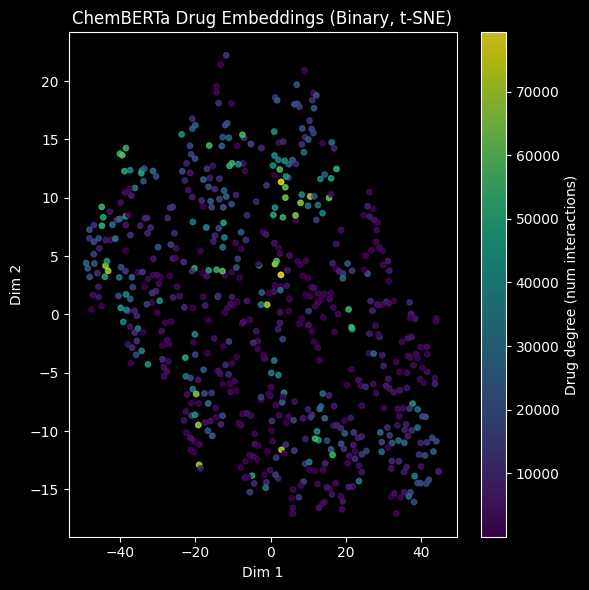

array([[-21.250185 , -11.623473 ],
       [-32.553185 ,   3.0407395],
       [-46.97969  ,   5.165815 ],
       ...,
       [ 32.09063  , -13.212847 ],
       [ 40.705982 ,  -5.8758845],
       [ -7.7477655,   5.597049 ]], shape=(645, 2), dtype=float32)

In [43]:
print("\n[t-SNE] ChemBERTa MLP (Binary)")
if 'drug_degree_map' not in globals():
    combo_deg = pd.read_csv(base_path + 'bio-decagon-combo.csv', usecols=['STITCH 1', 'STITCH 2'])
    deg1 = combo_deg['STITCH 1'].astype(str).value_counts()
    deg2 = combo_deg['STITCH 2'].astype(str).value_counts()
    drug_degree_map = deg1.add(deg2, fill_value=0).to_dict()

plot_tsne_from_embedding_pickle(
    embeddings_file=base_path + 'refined_drug_embeddings_fixed.pkl',
    title='ChemBERTa Drug Embeddings (Binary, t-SNE)',
    degree_map=drug_degree_map
)

### Multi_label

In [28]:
def evaluate_saved_model(checkpoint_path, embeddings_file, combo_file, hierarchical=False):
    print(f"\n--- Evaluating Saved Model: {checkpoint_path} ---")
    
    # 1. Data Setup (Only need Test Set)
    if hierarchical:
        results = prepare_data_hierarchical(
            embeddings_file, 
            combo_file, 
            map_file=base_path + 'bio-decagon-effectcategories.csv',
            is_binary_task=False
        )
        X_train_pairs, X_val_pairs, X_test_pairs, y_train, y_val, y_test, emb_map, N_CLASSES = results
    else:
        results = prepare_data(embeddings_file, combo_file, is_binary_task=False)
        X_train_pairs, X_val_pairs, X_test_pairs, y_train, y_val, y_test, emb_map, N_CLASSES = results
    
    test_dataset = DrugPairDataset(X_test_pairs, emb_map, y_test, is_binary=False)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
    
    # 2. Model Setup
    model = CrossAttentionFusion(embed_dim=D_EMB, num_output_classes=N_CLASSES, is_binary=False).to(DEVICE)
    
    # 3. Load Checkpoint
    if os.path.exists(checkpoint_path):
        checkpoint = torch.load(checkpoint_path, map_location=DEVICE)
        model.load_state_dict(checkpoint['model_state_dict'])
        print(f"Loaded weights from epoch {checkpoint['epoch']}")
    else:
        print(f"Error: Checkpoint {checkpoint_path} not found.")
        return

    # 4. Evaluation Loop
    model.eval()
    all_preds_proba, all_labels = [], []
    with torch.no_grad():
        for emb_a, emb_b, labels in test_loader:
            emb_a, emb_b = emb_a.to(DEVICE), emb_b.to(DEVICE)
            
            # Get logits and apply sigmoid
            logits = model(emb_a, emb_b)
            preds_tensor = torch.sigmoid(logits).cpu().detach()
            preds = np.array(preds_tensor.tolist())
            all_preds_proba.extend(preds)
            
            all_labels.extend(labels.cpu().tolist())
    
    all_preds_proba = np.array(all_preds_proba)
    all_labels = np.array(all_labels)
    all_preds = (all_preds_proba > 0.5).astype(int)
    
    # --- METRICS ---
    # F1 Scores
    f1_micro = f1_score(all_labels, all_preds, average='micro', zero_division=0)
    f1_macro = f1_score(all_labels, all_preds, average='macro', zero_division=0)
    
    # AUROC
    try:
        auroc_micro = roc_auc_score(all_labels, all_preds_proba, average='micro')
        auroc_macro = roc_auc_score(all_labels, all_preds_proba, average='macro')
    except Exception:
        auroc_micro, auroc_macro = 0.0, 0.0
    
    # AUPR
    try:
        aupr_micro = average_precision_score(all_labels, all_preds_proba, average='micro')
        aupr_macro = average_precision_score(all_labels, all_preds_proba, average='macro')
    except Exception:
        aupr_micro, aupr_macro = 0.0, 0.0
        
    # P@50 (Requires get_precision_at_k helper)
    try:
        p_at_50 = get_precision_at_k(all_labels, all_preds_proba, k=50)
    except Exception:
        p_at_50 = 0.0
    
    print("\n--- Final Evaluation Metrics (Saved Model) ---")
    print(f"F1 Score (Micro): {f1_micro:.4f}")
    print(f"F1 Score (Macro): {f1_macro:.4f}")
    print(f"AUROC (Micro):    {auroc_micro:.4f}")
    print(f"AUROC (Macro):    {auroc_macro:.4f}")
    print(f"AUPR (Micro):     {aupr_micro:.4f}")
    print(f"AUPR (Macro):     {aupr_macro:.4f}")
    print(f"P@50:             {p_at_50:.4f}")

In [29]:
def get_precision_at_k(y_true, y_prob, k=50):
    # y_true: binary labels (N, C)
    # y_prob: predicted probabilities (N, C)
    top_k_indices = np.argsort(y_prob, axis=1)[:, ::-1][:, :k]
    precision_sum = 0.0
    n_samples = y_true.shape[0]
    for i in range(n_samples):
        true_labels = y_true[i]
        pred_indices = top_k_indices[i]
        num_correct = np.sum(true_labels[pred_indices])
        precision_at_k = num_correct / k
        precision_sum += precision_at_k
    return precision_sum / n_samples

In [30]:
def run_multi_label_training(embeddings_file, combo_file, epochs=20, hierarchical=False):
    print("\n--- Starting Multi-Label Classification with Cross-Attention (Long-Tailed) ---")

    # 1. Data Setup (Long-Tailed/Unbalanced)
    # Both prepare_data functions now return 8 values (3 sets of X/y + map + classes)
    if hierarchical:
        results = prepare_data_hierarchical(
            embeddings_file,
            combo_file,
            map_file=base_path + 'bio-decagon-effectcategories.csv',
            is_binary_task=False
        )
        # Unpack 3 sets
        X_train_pairs, X_val_pairs, X_test_pairs, y_train, y_val, y_test, emb_map, N_CLASSES = results
    else:
        results = prepare_data(embeddings_file, combo_file, is_binary_task=False)
        X_train_pairs, X_val_pairs, X_test_pairs, y_train, y_val, y_test, emb_map, N_CLASSES = results

    print(f"   -> Training on {len(X_train_pairs)} samples")
    print(f"   -> Validating on {len(X_val_pairs)} samples")
    print(f"   -> Testing on {len(X_test_pairs)} samples")

    train_dataset = DrugPairDataset(X_train_pairs, emb_map, y_train, is_binary=False)
    val_dataset = DrugPairDataset(X_val_pairs, emb_map, y_val, is_binary=False)
    test_dataset = DrugPairDataset(X_test_pairs, emb_map, y_test, is_binary=False)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    # 2. Model Setup
    model = CrossAttentionFusion(embed_dim=D_EMB, num_output_classes=N_CLASSES, is_binary=False).to(DEVICE)

    criterion = FocalLoss(alpha=0.25, gamma=2).to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    
    # Create GradScaler for mixed precision training
    scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())

    best_metric = 0.0
    if hierarchical:
        task_name = "multi_label_hierarchical"
    else:
        task_name = "multi_label_focal"

    # 3. Training and Saving Checkpoint (Using Validation Set)
    for epoch in range(epochs):
        train_loss = train_model(model, train_loader, optimizer, criterion, scaler)

        # Evaluate on VALIDATION set
        current_metric, metric_name = evaluate_model(model, val_loader, is_binary=False)

        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Val {metric_name}: {current_metric:.4f}")

        if current_metric > best_metric:
            best_metric = current_metric
            print(f"  --> New best model saved (Val)! {metric_name}: {best_metric:.4f}")
            save_checkpoint(
                model,
                optimizer,
                epoch,
                {metric_name: current_metric},
                filename=f'{task_name}_best_model.pth'
            )

    # 4. Final Evaluation on TEST Set (loading best model)
    print("\n--- Final Evaluation on TEST SET (Using Best Validation Model) ---")
    if os.path.exists(f'{task_name}_best_model.pth'):
        checkpoint = torch.load(f'{task_name}_best_model.pth', map_location=DEVICE)
        model.load_state_dict(checkpoint['model_state_dict'])
        print(f"Loaded best model from epoch {checkpoint['epoch']}")

    model.eval()
    all_preds_proba, all_labels = [], []
    with torch.no_grad():
        for emb_a, emb_b, labels in test_loader:
            # Move tensors to device
            emb_a, emb_b = emb_a.to(DEVICE), emb_b.to(DEVICE)

            # Get logits and apply sigmoid
            logits = model(emb_a, emb_b)
            preds_tensor = torch.sigmoid(logits).cpu().detach()
            preds = np.array(preds_tensor.tolist())
            all_preds_proba.extend(preds)

            all_labels.extend(labels.cpu().tolist())

    all_preds_proba = np.array(all_preds_proba)
    all_labels = np.array(all_labels)
    all_preds = (all_preds_proba > 0.5).astype(int)

    # --- METRICS CALCULATION ---
    f1_micro = f1_score(all_labels, all_preds, average='micro', zero_division=0)
    f1_macro = f1_score(all_labels, all_preds, average='macro', zero_division=0)

    try:
        auroc_micro = roc_auc_score(all_labels, all_preds_proba, average='micro')
    except Exception as e:
        print(f"Warning: AUROC failed: {e}")
        auroc_micro = 0.0

    try:
        aupr_micro = average_precision_score(all_labels, all_preds_proba, average='micro')
    except Exception as e:
        print(f"Warning: AUPR failed: {e}")
        aupr_micro = 0.0

    # Calculate P@50 using helper
    try:
        p_at_50 = get_precision_at_k(all_labels, all_preds_proba, k=50)
    except Exception as e:
        print(f"Warning: P@50 failed: {e}")
        p_at_50 = 0.0

    print(f"F1 Score (Micro): {f1_micro:.4f}")
    print(f"F1 Score (Macro): {f1_macro:.4f}")
    print(f"AUROC (Micro):    {auroc_micro:.4f}")
    print(f"AUPR (Micro):     {aupr_micro:.4f}")
    print(f"P@50:             {p_at_50:.4f}")

    results_df = pd.DataFrame({
        'Task': [task_name],
        'Model': ['Cross-Attention'],
        'Epochs': [epochs],
        'AUROC': [auroc_micro],
        'AUPR': [aupr_micro],
        'P@50': [p_at_50],
        'F1_Micro': [f1_micro],
        'F1_Macro': [f1_macro],
        'Best_Metric': [best_metric]
    })
    if hierarchical:
        save_results(results_df, 'experiment_results_chemberta_2_hierarchical.csv')
    else:
        save_results(results_df, 'experiment_results_chemberta_2.csv')

In [31]:
EMBEDDINGS_FILE = base_path + 'refined_drug_embeddings_fixed.pkl'
COMBO_FILE = base_path + 'bio-decagon-combo.csv'
NUM_EPOCH = 20
print("\n[PHASE 2] Running Multi-Label Classification (Balanced Data)")
start_time_binary = time.time()

run_multi_label_training(
        embeddings_file=EMBEDDINGS_FILE,
        combo_file=COMBO_FILE,
        epochs=NUM_EPOCHS,
        hierarchical=False
    )

end_time_binary = time.time()
print(f"\n✅ PHASE 2 Complete. Time taken: {end_time_binary - start_time_binary:.2f} seconds.")


[PHASE 2] Running Multi-Label Classification (Balanced Data)

--- Starting Multi-Label Classification with Cross-Attention (Long-Tailed) ---
1. Loading ChemBERTa embeddings from /root/autodl-tmp/FinalProjectRemote/ChemBERTa/refined_drug_embeddings_fixed.pkl...
   -> Loaded 645 unique drug embeddings.
Filtering side effects (>= 500 occurrences)...
Original unique side effects: 1317
Keeping 963 unique side effects.
Filtered dataset size: 4576287 rows.
   -> Preparing data for MULTI-LABEL classification...
2. Found 63472 unique, embedded drug pairs.
   -> MultiLabelBinarizer found 963 total unique side effects.
   -> Split Stats: Train=50777 (80%), Val=6347 (10%), Test=6348 (10%)
   -> Training on 50777 samples
   -> Validating on 6347 samples
   -> Testing on 6348 samples


/tmp/ipykernel_39243/4242313721.py:38: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())
/tmp/ipykernel_39243/2290142904.py:138: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


Epoch 1/20 | Train Loss: 0.0229 | Val F1-Micro: 0.0002
  --> New best model saved (Val)! F1-Micro: 0.0002
Checkpoint saved to multi_label_focal_best_model.pth


/tmp/ipykernel_39243/2290142904.py:138: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


Epoch 2/20 | Train Loss: 0.0212 | Val F1-Micro: 0.0012
  --> New best model saved (Val)! F1-Micro: 0.0012
Checkpoint saved to multi_label_focal_best_model.pth


/tmp/ipykernel_39243/2290142904.py:138: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


Epoch 3/20 | Train Loss: 0.0208 | Val F1-Micro: 0.0014
  --> New best model saved (Val)! F1-Micro: 0.0014
Checkpoint saved to multi_label_focal_best_model.pth


/tmp/ipykernel_39243/2290142904.py:138: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


Epoch 4/20 | Train Loss: 0.0205 | Val F1-Micro: 0.0018
  --> New best model saved (Val)! F1-Micro: 0.0018
Checkpoint saved to multi_label_focal_best_model.pth


/tmp/ipykernel_39243/2290142904.py:138: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


Epoch 5/20 | Train Loss: 0.0203 | Val F1-Micro: 0.0053
  --> New best model saved (Val)! F1-Micro: 0.0053
Checkpoint saved to multi_label_focal_best_model.pth


/tmp/ipykernel_39243/2290142904.py:138: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


Epoch 6/20 | Train Loss: 0.0201 | Val F1-Micro: 0.0022


/tmp/ipykernel_39243/2290142904.py:138: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


Epoch 7/20 | Train Loss: 0.0200 | Val F1-Micro: 0.0041


/tmp/ipykernel_39243/2290142904.py:138: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


Epoch 8/20 | Train Loss: 0.0199 | Val F1-Micro: 0.0099
  --> New best model saved (Val)! F1-Micro: 0.0099
Checkpoint saved to multi_label_focal_best_model.pth


/tmp/ipykernel_39243/2290142904.py:138: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


Epoch 9/20 | Train Loss: 0.0198 | Val F1-Micro: 0.0074


/tmp/ipykernel_39243/2290142904.py:138: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


Epoch 10/20 | Train Loss: 0.0197 | Val F1-Micro: 0.0104
  --> New best model saved (Val)! F1-Micro: 0.0104
Checkpoint saved to multi_label_focal_best_model.pth


/tmp/ipykernel_39243/2290142904.py:138: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


Epoch 11/20 | Train Loss: 0.0196 | Val F1-Micro: 0.0068


/tmp/ipykernel_39243/2290142904.py:138: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


Epoch 12/20 | Train Loss: 0.0195 | Val F1-Micro: 0.0056


/tmp/ipykernel_39243/2290142904.py:138: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


Epoch 13/20 | Train Loss: 0.0194 | Val F1-Micro: 0.0070


/tmp/ipykernel_39243/2290142904.py:138: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


Epoch 14/20 | Train Loss: 0.0194 | Val F1-Micro: 0.0110
  --> New best model saved (Val)! F1-Micro: 0.0110
Checkpoint saved to multi_label_focal_best_model.pth


/tmp/ipykernel_39243/2290142904.py:138: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


Epoch 15/20 | Train Loss: 0.0193 | Val F1-Micro: 0.0185
  --> New best model saved (Val)! F1-Micro: 0.0185
Checkpoint saved to multi_label_focal_best_model.pth


/tmp/ipykernel_39243/2290142904.py:138: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


Epoch 16/20 | Train Loss: 0.0192 | Val F1-Micro: 0.0172


/tmp/ipykernel_39243/2290142904.py:138: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


Epoch 17/20 | Train Loss: 0.0192 | Val F1-Micro: 0.0176


/tmp/ipykernel_39243/2290142904.py:138: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


Epoch 18/20 | Train Loss: 0.0191 | Val F1-Micro: 0.0186
  --> New best model saved (Val)! F1-Micro: 0.0186
Checkpoint saved to multi_label_focal_best_model.pth


/tmp/ipykernel_39243/2290142904.py:138: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


Epoch 19/20 | Train Loss: 0.0191 | Val F1-Micro: 0.0238
  --> New best model saved (Val)! F1-Micro: 0.0238
Checkpoint saved to multi_label_focal_best_model.pth


/tmp/ipykernel_39243/2290142904.py:138: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


Epoch 20/20 | Train Loss: 0.0190 | Val F1-Micro: 0.0153

--- Final Evaluation on TEST SET (Using Best Validation Model) ---
Loaded best model from epoch 18
F1 Score (Micro): 0.0262
F1 Score (Macro): 0.0082
AUROC (Micro):    0.8735
AUPR (Micro):     0.3909
P@50:             0.3587

--- Results saved to experiment_results_chemberta_2.csv ---

✅ PHASE 2 Complete. Time taken: 537.10 seconds.


In [38]:
metrics = evaluate_saved_model(
    checkpoint_path=base_path + 'multi_label_focal_best_model.pth',
    embeddings_file=base_path +'refined_drug_embeddings_fixed.pkl',
    combo_file=base_path +'bio-decagon-combo.csv',
    hierarchical=False  # Set to True if using hierarchical data
)


--- Evaluating Saved Model: /root/autodl-tmp/FinalProjectRemote/ChemBERTa/multi_label_focal_best_model.pth ---
1. Loading ChemBERTa embeddings from /root/autodl-tmp/FinalProjectRemote/ChemBERTa/refined_drug_embeddings_fixed.pkl...
   -> Loaded 645 unique drug embeddings.
Filtering side effects (>= 500 occurrences)...
Original unique side effects: 1317
Keeping 963 unique side effects.
Filtered dataset size: 4576287 rows.
   -> Preparing data for MULTI-LABEL classification...
2. Found 63472 unique, embedded drug pairs.
   -> MultiLabelBinarizer found 963 total unique side effects.
   -> Split Stats: Train=50777 (80%), Val=6347 (10%), Test=6348 (10%)
Loaded weights from epoch 18

--- Final Evaluation Metrics (Saved Model) ---
F1 Score (Micro): 0.0262
F1 Score (Macro): 0.0082
AUROC (Micro):    0.8735
AUROC (Macro):    0.8273
AUPR (Micro):     0.3909
AUPR (Macro):     0.2755
P@50:             0.3587



[t-SNE] ChemBERTa MLP (Multi-class Non-hierarchical)


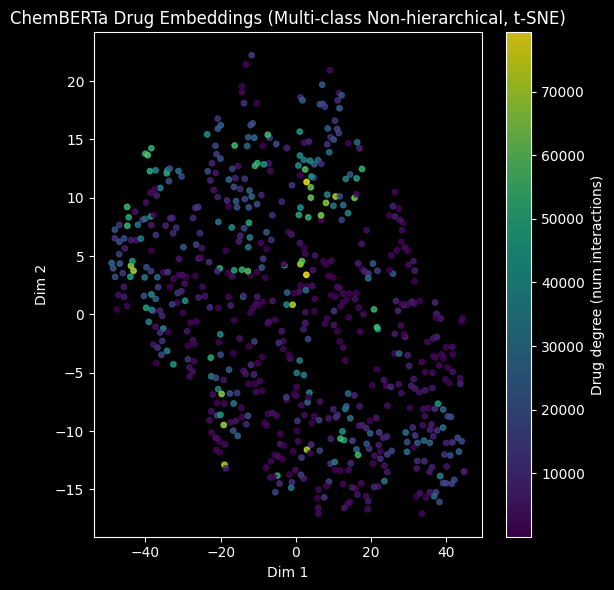

array([[-21.250185 , -11.623473 ],
       [-32.553185 ,   3.0407395],
       [-46.97969  ,   5.165815 ],
       ...,
       [ 32.09063  , -13.212847 ],
       [ 40.705982 ,  -5.8758845],
       [ -7.7477655,   5.597049 ]], shape=(645, 2), dtype=float32)

In [44]:
print("\n[t-SNE] ChemBERTa MLP (Multi-class Non-hierarchical)")
if 'drug_degree_map' not in globals():
    combo_deg = pd.read_csv(base_path + 'bio-decagon-combo.csv', usecols=['STITCH 1', 'STITCH 2'])
    deg_drug1 = combo_deg['STITCH 1'].astype(str).value_counts()
    deg_drug2 = combo_deg['STITCH 2'].astype(str).value_counts()
    drug_degree_map = deg_drug1.add(deg_drug2, fill_value=0).to_dict()

plot_tsne_from_embedding_pickle(
    embeddings_file=base_path + 'refined_drug_embeddings_fixed.pkl',
    title='ChemBERTa Drug Embeddings (Multi-class Non-hierarchical, t-SNE)',
    degree_map=drug_degree_map
)

In [33]:
EMBEDDINGS_FILE = base_path + 'refined_drug_embeddings_fixed.pkl'
COMBO_FILE = base_path + 'bio-decagon-combo.csv'
NUM_EPOCH = 20
print("\n[PHASE 3] Running Multi-Label Classification (hierarchical)")
start_time_binary = time.time()
    
run_multi_label_training(
        embeddings_file=EMBEDDINGS_FILE, 
        combo_file=COMBO_FILE, 
        epochs=NUM_EPOCHS,
        hierarchical=True
    )
    
end_time_binary = time.time()
print(f"\n✅ PHASE 3 Complete. Time taken: {end_time_binary - start_time_binary:.2f} seconds.")


[PHASE 3] Running Multi-Label Classification (hierarchical)

--- Starting Multi-Label Classification with Cross-Attention (Long-Tailed) ---
1. Loading Refined embeddings from /root/autodl-tmp/FinalProjectRemote/ChemBERTa/refined_drug_embeddings_fixed.pkl...
   -> Loaded 645 unique drug embeddings.
Filtering side effects (>= 500 occurrences)...
Original unique side effects: 1317
Keeping 963 unique side effects.
Filtered dataset size: 4576287 rows.
2. Loading hierarchical map from /root/autodl-tmp/FinalProjectRemote/ChemBERTa/bio-decagon-effectcategories.csv...
   -> Map built: 561 fine-grained effects mapped to categories.
3. Found 63472 unique, embedded drug pairs.
   -> Original # of Classes: 963
   -> New # of Classes: 592
   -> Split Stats: Train=50777 (80%), Val=6347 (10%), Test=6348 (10%)
   -> Training on 50777 samples
   -> Validating on 6347 samples
   -> Testing on 6348 samples


/tmp/ipykernel_39243/4242313721.py:38: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())
/tmp/ipykernel_39243/2290142904.py:138: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


Epoch 1/20 | Train Loss: 0.0257 | Val F1-Micro: 0.0998
  --> New best model saved (Val)! F1-Micro: 0.0998
Checkpoint saved to multi_label_hierarchical_best_model.pth


/tmp/ipykernel_39243/2290142904.py:138: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


Epoch 2/20 | Train Loss: 0.0238 | Val F1-Micro: 0.1240
  --> New best model saved (Val)! F1-Micro: 0.1240
Checkpoint saved to multi_label_hierarchical_best_model.pth


/tmp/ipykernel_39243/2290142904.py:138: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


Epoch 3/20 | Train Loss: 0.0234 | Val F1-Micro: 0.1361
  --> New best model saved (Val)! F1-Micro: 0.1361
Checkpoint saved to multi_label_hierarchical_best_model.pth


/tmp/ipykernel_39243/2290142904.py:138: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


Epoch 4/20 | Train Loss: 0.0231 | Val F1-Micro: 0.1362
  --> New best model saved (Val)! F1-Micro: 0.1362
Checkpoint saved to multi_label_hierarchical_best_model.pth


/tmp/ipykernel_39243/2290142904.py:138: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


Epoch 5/20 | Train Loss: 0.0228 | Val F1-Micro: 0.1503
  --> New best model saved (Val)! F1-Micro: 0.1503
Checkpoint saved to multi_label_hierarchical_best_model.pth


/tmp/ipykernel_39243/2290142904.py:138: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


Epoch 6/20 | Train Loss: 0.0227 | Val F1-Micro: 0.1382


/tmp/ipykernel_39243/2290142904.py:138: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


Epoch 7/20 | Train Loss: 0.0225 | Val F1-Micro: 0.1409


/tmp/ipykernel_39243/2290142904.py:138: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


Epoch 8/20 | Train Loss: 0.0224 | Val F1-Micro: 0.1482


/tmp/ipykernel_39243/2290142904.py:138: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


Epoch 9/20 | Train Loss: 0.0223 | Val F1-Micro: 0.1480


/tmp/ipykernel_39243/2290142904.py:138: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


Epoch 10/20 | Train Loss: 0.0222 | Val F1-Micro: 0.1333


/tmp/ipykernel_39243/2290142904.py:138: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


Epoch 11/20 | Train Loss: 0.0221 | Val F1-Micro: 0.1503
  --> New best model saved (Val)! F1-Micro: 0.1503
Checkpoint saved to multi_label_hierarchical_best_model.pth


/tmp/ipykernel_39243/2290142904.py:138: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


Epoch 12/20 | Train Loss: 0.0220 | Val F1-Micro: 0.1433


/tmp/ipykernel_39243/2290142904.py:138: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


Epoch 13/20 | Train Loss: 0.0219 | Val F1-Micro: 0.1529
  --> New best model saved (Val)! F1-Micro: 0.1529
Checkpoint saved to multi_label_hierarchical_best_model.pth


/tmp/ipykernel_39243/2290142904.py:138: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


Epoch 14/20 | Train Loss: 0.0218 | Val F1-Micro: 0.1357


/tmp/ipykernel_39243/2290142904.py:138: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


Epoch 15/20 | Train Loss: 0.0218 | Val F1-Micro: 0.1400


/tmp/ipykernel_39243/2290142904.py:138: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


Epoch 16/20 | Train Loss: 0.0217 | Val F1-Micro: 0.1622
  --> New best model saved (Val)! F1-Micro: 0.1622
Checkpoint saved to multi_label_hierarchical_best_model.pth


/tmp/ipykernel_39243/2290142904.py:138: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


Epoch 17/20 | Train Loss: 0.0216 | Val F1-Micro: 0.1346


/tmp/ipykernel_39243/2290142904.py:138: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


Epoch 18/20 | Train Loss: 0.0216 | Val F1-Micro: 0.1474


/tmp/ipykernel_39243/2290142904.py:138: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


Epoch 19/20 | Train Loss: 0.0215 | Val F1-Micro: 0.1340


/tmp/ipykernel_39243/2290142904.py:138: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


Epoch 20/20 | Train Loss: 0.0215 | Val F1-Micro: 0.1628
  --> New best model saved (Val)! F1-Micro: 0.1628
Checkpoint saved to multi_label_hierarchical_best_model.pth

--- Final Evaluation on TEST SET (Using Best Validation Model) ---
Loaded best model from epoch 19
F1 Score (Micro): 0.1646
F1 Score (Macro): 0.0254
AUROC (Micro):    0.8804
AUPR (Micro):     0.4964
P@50:             0.4200

--- Results saved to experiment_results_chemberta_2_hierarchical.csv ---

✅ PHASE 3 Complete. Time taken: 523.26 seconds.


In [37]:
metrics_h = evaluate_saved_model(
    checkpoint_path=base_path +'multi_label_hierarchical_best_model.pth',
    embeddings_file=base_path +'refined_drug_embeddings_fixed.pkl',
    combo_file=base_path +'bio-decagon-combo.csv',
    hierarchical=True  # Set to True if using hierarchical data
)


--- Evaluating Saved Model: /root/autodl-tmp/FinalProjectRemote/ChemBERTa/multi_label_hierarchical_best_model.pth ---
1. Loading Refined embeddings from /root/autodl-tmp/FinalProjectRemote/ChemBERTa/refined_drug_embeddings_fixed.pkl...
   -> Loaded 645 unique drug embeddings.
Filtering side effects (>= 500 occurrences)...
Original unique side effects: 1317
Keeping 963 unique side effects.
Filtered dataset size: 4576287 rows.
2. Loading hierarchical map from /root/autodl-tmp/FinalProjectRemote/ChemBERTa/bio-decagon-effectcategories.csv...
   -> Map built: 561 fine-grained effects mapped to categories.
3. Found 63472 unique, embedded drug pairs.
   -> Original # of Classes: 963
   -> New # of Classes: 592
   -> Split Stats: Train=50777 (80%), Val=6347 (10%), Test=6348 (10%)
Loaded weights from epoch 19

--- Final Evaluation Metrics (Saved Model) ---
F1 Score (Micro): 0.1646
F1 Score (Macro): 0.0254
AUROC (Micro):    0.8804
AUROC (Macro):    0.8206
AUPR (Micro):     0.4964
AUPR (Macro): 


[t-SNE] ChemBERTa MLP (Multi-class Hierarchical)


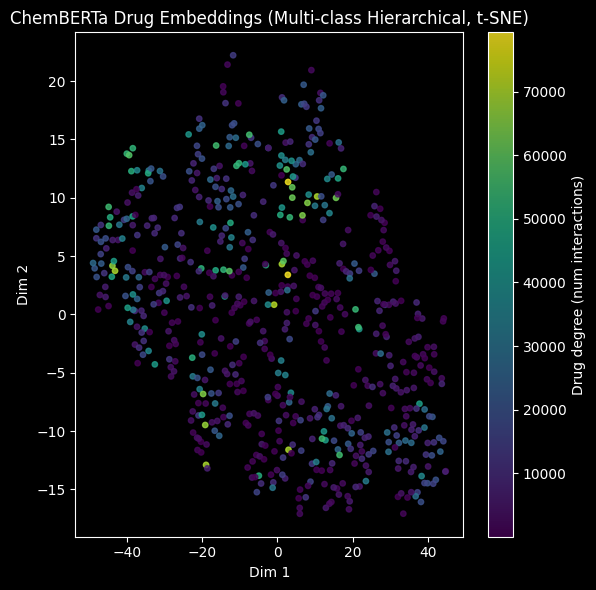

array([[-21.250185 , -11.623473 ],
       [-32.553185 ,   3.0407395],
       [-46.97969  ,   5.165815 ],
       ...,
       [ 32.09063  , -13.212847 ],
       [ 40.705982 ,  -5.8758845],
       [ -7.7477655,   5.597049 ]], shape=(645, 2), dtype=float32)

In [45]:
print("\n[t-SNE] ChemBERTa MLP (Multi-class Hierarchical)")
if 'drug_degree_map' not in globals():
    combo_deg = pd.read_csv(base_path + 'bio-decagon-combo.csv', usecols=['STITCH 1', 'STITCH 2'])
    deg_drug1 = combo_deg['STITCH 1'].astype(str).value_counts()
    deg_drug2 = combo_deg['STITCH 2'].astype(str).value_counts()
    drug_degree_map = deg_drug1.add(deg_drug2, fill_value=0).to_dict()

plot_tsne_from_embedding_pickle(
    embeddings_file=base_path + 'refined_drug_embeddings_fixed.pkl',
    title='ChemBERTa Drug Embeddings (Multi-class Hierarchical, t-SNE)',
    degree_map=drug_degree_map
)